In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import quench
from migdalcalc.migdal import ionization as ion
from migdalcalc.migdal import kinematics as kin

In [2]:
Si_migdal = mc.migdalcalc(target="Si-28", nuclear_data_name="jeff33")

In [3]:
Angles = [10, 72]
Energies = [2*1e3, 23*1e3, 54*1e3, 2507*1e3]

YL = lambda E: quench.Lindhard_Factor(E, 14, 28)
YS = lambda E: quench.Y_Si_sarkis(E)

In [4]:
A = Si_migdal.A
N_per_g = (6.02e23/A)
barns_to_cm2 = 1e-24
flux = 1e3 #nuetrons/cm^2/second
seconds_to_days = 60*60*24 #seconds to days
phi_int = 2*np.pi #integral over phi
thickness = 1 #1 cm
density =  4.99e22 #per cubic cm

xsec_to_events_per_nuetron = density*thickness*barns_to_cm2*phi_int
xsec_to_inv_gram_days = flux*N_per_g*barns_to_cm2*seconds_to_days*phi_int

flux_factor=xsec_to_events_per_nuetron

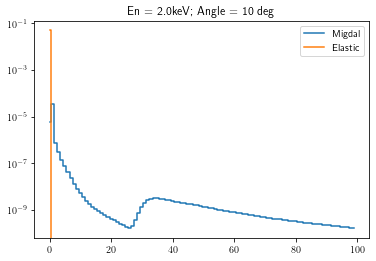

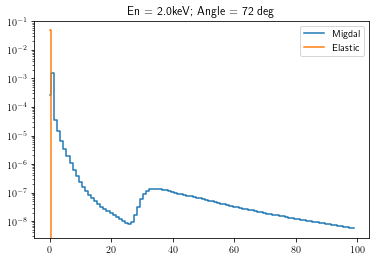

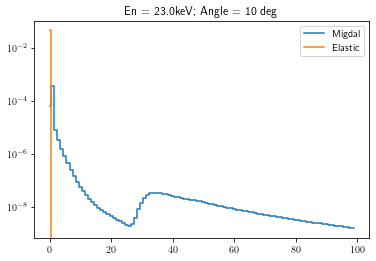

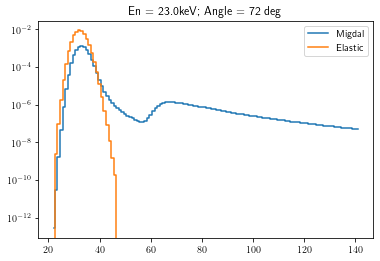

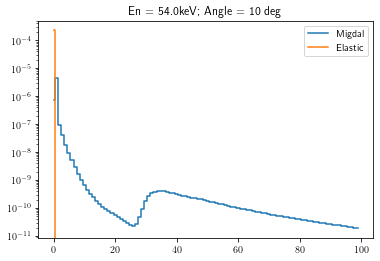

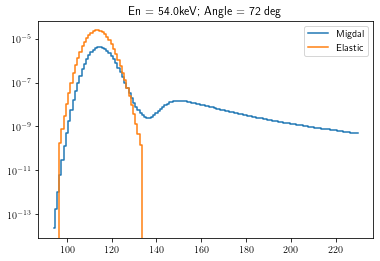

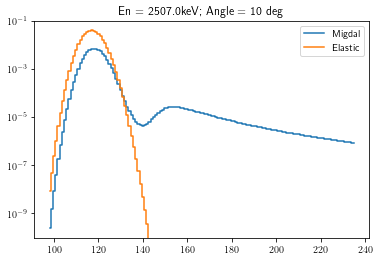

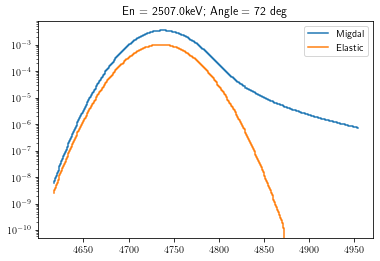

In [5]:
for En in Energies:
    elastic_spectrum = Si_migdal.nuc.dSig_dOmega(En)
    
    for angle in Angles:
        save_folder = './output/' + str(int(1e-3*En)) + 'keV/' + str(angle) + 'deg/' 
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
            
        c = np.cos(angle*np.pi/180)
        
        Si_ion_spec_sarkis = Si_migdal.dR_dEion(c, En, YS, "elf-ibe")
        Si_ion_spec_lind   = Si_migdal.dR_dEion(c, En, YL, "elf-ibe")
        
        ER_Q_sarkis = kin.E_R_elastic(c, A, En)*YS(kin.E_R_elastic(c, A, En))
        ER_Q_lind   = kin.E_R_elastic(c, A, En)*YL(kin.E_R_elastic(c, A, En))
        
        elastic_rate = flux_factor*elastic_spectrum(c)
        
        #Estimate the first and last electron bins we need to consider
        fano = 0.119 #fano factor
        eps  = 3.8 #energy per eh pair
        n_base_sarkis = np.floor(ER_Q_sarkis/eps)
        n_base_lind   = np.floor(ER_Q_lind/eps)
        
        first_n_sarkis = max(np.floor(ER_Q_sarkis/eps) - 5*np.sqrt(fano*n_base_sarkis), 0)
        first_n_lind   = max(np.floor(ER_Q_lind/eps)   - 5*np.sqrt(fano*n_base_lind), 0)
        
        final_n_sarkis = np.floor(ER_Q_sarkis/eps) + 5*np.sqrt(fano*n_base_sarkis) + 100
        final_n_lind   = np.floor(ER_Q_lind/eps)   + 5*np.sqrt(fano*n_base_lind) + 100
        
        n_bins_sarkis = final_n_sarkis - first_n_sarkis
        n_bins_lind   = final_n_lind   - first_n_lind
        
        n_sarkis, r_sarkis = ion.Si_electron_spectrum(Si_ion_spec_sarkis, ER_Q_sarkis, \
                                                      start_bin=first_n_sarkis, number_of_bins=n_bins_sarkis,flux=flux_factor)
        n_lind, r_lind     = ion.Si_electron_spectrum(Si_ion_spec_lind, ER_Q_lind, \
                                                      start_bin=first_n_lind, number_of_bins=n_bins_lind,flux=flux_factor)
        
        n_el_sarkis, r_el_sarkis = ion.Si_elastic_electron_spectrum_fixed_angle(ER_Q_sarkis, elastic_rate, \
                                                                               start_bin=first_n_sarkis, number_of_bins=n_bins_sarkis)
        n_el_lind, r_el_lind     = ion.Si_elastic_electron_spectrum_fixed_angle(ER_Q_lind, elastic_rate, \
                                                                               start_bin=first_n_lind, number_of_bins=n_bins_lind)
        
        plt.step(n_sarkis, r_sarkis, where='mid',label='Migdal')
        plt.step(n_el_sarkis, r_el_sarkis, where='mid',label='Elastic')
        plt.title("En = " + str(1e-3*En) + "keV; Angle = " + str(angle) + " deg")
        plt.legend()
        plt.yscale('log')
        
        plt.show()
        
        np.savetxt(save_folder + 'Ne_sarkis_migdal.csv', list(zip(n_sarkis, r_sarkis)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
                   
        np.savetxt(save_folder + 'Ne_sarkis_elastic.csv', list(zip(n_el_sarkis, r_el_sarkis)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
        
        np.savetxt(save_folder + 'Ne_lindhard_migdal.csv', list(zip(n_lind, r_lind)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
                   
        np.savetxt(save_folder + 'Ne_lindhard_elastic.csv', list(zip(n_el_lind, r_el_lind)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
